In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import optuna


In [2]:
# Paths
base_path = '../Competition_data'
dataset_folders = os.listdir(base_path)

In [3]:
# Define a function for hyperparameter tuning using Optuna
def tune_nn_model(trial, input_dim):
    model = Sequential()
    # Suggest number of units for each layer
    n_units_1 = trial.suggest_int('n_units_1', 64, 256)
    n_units_2 = trial.suggest_int('n_units_2', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)

    model.add(Dense(n_units_1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# Loop through each dataset folder
for dataset in dataset_folders:
    dataset_path = os.path.join(base_path, dataset)

    # Load data
    X_train = pd.read_csv(os.path.join(dataset_path, 'X_train.csv'))
    y_train = pd.read_csv(os.path.join(dataset_path, 'y_train.csv'))
    X_test = pd.read_csv(os.path.join(dataset_path, 'X_test.csv'))

    # Data Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Test Split
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

    print(f"Dataset: {dataset}")
    print(f"X_train_split shape: {X_train_split.shape}")
    print(f"y_train_split shape: {y_train_split.shape}")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    
    # Hyperparameter Tuning with Optuna
    def objective(trial):
        try:
            model = tune_nn_model(trial, X_train.shape[1])
            history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)
            val_accuracy = max(history.history['val_accuracy'])
            return val_accuracy
        except Exception as e:
            print(f"Trial failed due to: {e}")
            return None

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)

    # Train Final Model with Best Parameters
    best_params = study.best_params
    model = Sequential()
    model.add(Dense(best_params['n_units_1'], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(best_params['n_units_2'], activation='relu'))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

    # Evaluate the Model
    y_val_pred = (model.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Custom Score
    score = accuracy * 0.3 + precision * 0.4 + f1 * 0.3
    print(f"Dataset: {dataset}, Score: {score:.4f}")

    # Inference on Test Set
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred_percentage = y_test_pred.flatten()  # Keep values between 0.0 and 1.0 for probability of 1

    # Save Predictions
    y_predict_path = os.path.join(dataset_path, 'y_predict.csv')
    pd.DataFrame({'Prediction': y_test_pred_percentage}).to_csv(y_predict_path, index=False)

[I 2024-11-05 12:24:45,477] A new study created in memory with name: no-name-90386ae9-1a71-4d7a-812d-3cd6f2923f2a


Dataset: Dataset_2
X_train_split shape: (372, 24)
y_train_split shape: (372, 1)
X_train shape: (465, 24)
y_train shape: (465, 1)


[I 2024-11-05 12:24:46,397] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 133, 'n_units_2': 62, 'dropout_rate': 0.4507582116372672}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:24:47,255] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 147, 'n_units_2': 54, 'dropout_rate': 0.4460545077279146}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:24:48,116] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 243, 'n_units_2': 55, 'dropout_rate': 0.324739086626695}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:24:49,052] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 105, 'n_units_2': 88, 'dropout_rate': 0.3191179010199267}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:24:49,924] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 195, 'n_units_2': 125, 'dropout_rate': 0.457393497806785}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:24:50,790] Trial 5 finished with value: 1.0 and parameters: {'n_units

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_2, Score: 0.9928
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


[I 2024-11-05 12:24:56,019] A new study created in memory with name: no-name-de5921e5-5daa-4e39-8fad-fe6a59ca95b5


Dataset: Dataset_35
X_train_split shape: (368, 8)
y_train_split shape: (368, 1)
X_train shape: (460, 8)
y_train shape: (460, 1)


[I 2024-11-05 12:24:56,893] Trial 0 finished with value: 0.79347825050354 and parameters: {'n_units_1': 205, 'n_units_2': 88, 'dropout_rate': 0.2785362112615742}. Best is trial 0 with value: 0.79347825050354.
[I 2024-11-05 12:24:57,757] Trial 1 finished with value: 0.782608687877655 and parameters: {'n_units_1': 112, 'n_units_2': 61, 'dropout_rate': 0.2313787283074398}. Best is trial 0 with value: 0.79347825050354.
[I 2024-11-05 12:24:58,625] Trial 2 finished with value: 0.782608687877655 and parameters: {'n_units_1': 164, 'n_units_2': 59, 'dropout_rate': 0.4703030167002157}. Best is trial 0 with value: 0.79347825050354.
[I 2024-11-05 12:24:59,506] Trial 3 finished with value: 0.782608687877655 and parameters: {'n_units_1': 126, 'n_units_2': 67, 'dropout_rate': 0.2969481263330367}. Best is trial 0 with value: 0.79347825050354.
[I 2024-11-05 12:25:00,361] Trial 4 finished with value: 0.804347813129425 and parameters: {'n_units_1': 242, 'n_units_2': 37, 'dropout_rate': 0.3970152358176612

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Dataset: Dataset_35, Score: 0.7005
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


[I 2024-11-05 12:25:06,722] A new study created in memory with name: no-name-984fb368-95d5-4d2f-97f5-05d24643e3e4


Dataset: Dataset_5
X_train_split shape: (259, 19)
y_train_split shape: (259, 1)
X_train shape: (324, 19)
y_train shape: (324, 1)


[I 2024-11-05 12:25:07,593] Trial 0 finished with value: 0.9384615421295166 and parameters: {'n_units_1': 140, 'n_units_2': 123, 'dropout_rate': 0.3236536092103278}. Best is trial 0 with value: 0.9384615421295166.
[I 2024-11-05 12:25:08,430] Trial 1 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 95, 'n_units_2': 76, 'dropout_rate': 0.20676467238353413}. Best is trial 0 with value: 0.9384615421295166.
[I 2024-11-05 12:25:09,289] Trial 2 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 92, 'n_units_2': 69, 'dropout_rate': 0.40639668824944075}. Best is trial 0 with value: 0.9384615421295166.
[I 2024-11-05 12:25:10,126] Trial 3 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 145, 'n_units_2': 108, 'dropout_rate': 0.37396686618266023}. Best is trial 0 with value: 0.9384615421295166.
[I 2024-11-05 12:25:11,191] Trial 4 finished with value: 0.9384615421295166 and parameters: {'n_units_1': 142, 'n_units_2': 121, 'dropout_rate': 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_5, Score: 0.7815
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


[I 2024-11-05 12:25:17,355] A new study created in memory with name: no-name-f6e77071-3fc0-4b94-8f20-73a46b12fefe


Dataset: Dataset_32
X_train_split shape: (474, 4)
y_train_split shape: (474, 1)
X_train shape: (593, 4)
y_train shape: (593, 1)


[I 2024-11-05 12:25:18,279] Trial 0 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 98, 'n_units_2': 78, 'dropout_rate': 0.3873543568355548}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:25:19,214] Trial 1 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 124, 'n_units_2': 58, 'dropout_rate': 0.398258771259694}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:25:20,133] Trial 2 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 120, 'n_units_2': 91, 'dropout_rate': 0.49640540350302254}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:25:21,035] Trial 3 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 164, 'n_units_2': 65, 'dropout_rate': 0.24528017341981606}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:25:22,196] Trial 4 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 239, 'n_units_2': 122, 'dropout_rate': 0.2

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_32, Score: 0.2622
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


[I 2024-11-05 12:25:28,616] A new study created in memory with name: no-name-54193994-e14c-459a-bfdc-fbad31e3f877


Dataset: Dataset_4
X_train_split shape: (411, 30)
y_train_split shape: (411, 1)
X_train shape: (514, 30)
y_train shape: (514, 1)


[I 2024-11-05 12:25:29,497] Trial 0 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 114, 'n_units_2': 63, 'dropout_rate': 0.4338574587645223}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-05 12:25:30,439] Trial 1 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 226, 'n_units_2': 72, 'dropout_rate': 0.35151487400946735}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-05 12:25:31,366] Trial 2 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 240, 'n_units_2': 101, 'dropout_rate': 0.354946144282387}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-05 12:25:32,261] Trial 3 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 224, 'n_units_2': 125, 'dropout_rate': 0.3326988183118759}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-05 12:25:33,380] Trial 4 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 71, 'n_units_2': 78, 'dropout_rate': 0.3

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Dataset: Dataset_4, Score: 0.2854
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


[I 2024-11-05 12:25:39,927] A new study created in memory with name: no-name-1b0b8232-80c7-4e92-aad7-0ffa5a6d38e3


Dataset: Dataset_33
X_train_split shape: (192, 13)
y_train_split shape: (192, 1)
X_train shape: (240, 13)
y_train shape: (240, 1)


[I 2024-11-05 12:25:40,765] Trial 0 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 73, 'n_units_2': 89, 'dropout_rate': 0.48375873112900175}. Best is trial 0 with value: 0.9583333134651184.
[I 2024-11-05 12:25:41,619] Trial 1 finished with value: 0.9791666865348816 and parameters: {'n_units_1': 182, 'n_units_2': 47, 'dropout_rate': 0.34417966415874146}. Best is trial 1 with value: 0.9791666865348816.
[I 2024-11-05 12:25:42,515] Trial 2 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 151, 'n_units_2': 33, 'dropout_rate': 0.29910427233378273}. Best is trial 1 with value: 0.9791666865348816.
[I 2024-11-05 12:25:43,378] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 171, 'n_units_2': 73, 'dropout_rate': 0.47694629019725426}. Best is trial 3 with value: 1.0.
[I 2024-11-05 12:25:44,519] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 248, 'n_units_2': 38, 'dropout_rate': 0.25058467311661087}. Best is trial 3 with val

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Dataset: Dataset_33, Score: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


[I 2024-11-05 12:25:49,790] A new study created in memory with name: no-name-6999b62e-85f1-4e0f-9c20-06c5708832ab


Dataset: Dataset_3
X_train_split shape: (55, 9)
y_train_split shape: (55, 1)
X_train shape: (69, 9)
y_train shape: (69, 1)


[I 2024-11-05 12:25:50,947] Trial 0 finished with value: 0.7857142686843872 and parameters: {'n_units_1': 193, 'n_units_2': 35, 'dropout_rate': 0.4927828528544636}. Best is trial 0 with value: 0.7857142686843872.
[I 2024-11-05 12:25:51,724] Trial 1 finished with value: 0.8571428656578064 and parameters: {'n_units_1': 100, 'n_units_2': 126, 'dropout_rate': 0.47951907342066735}. Best is trial 1 with value: 0.8571428656578064.
[I 2024-11-05 12:25:52,512] Trial 2 finished with value: 0.7142857313156128 and parameters: {'n_units_1': 192, 'n_units_2': 112, 'dropout_rate': 0.28999867961229064}. Best is trial 1 with value: 0.8571428656578064.
[I 2024-11-05 12:25:53,303] Trial 3 finished with value: 0.7142857313156128 and parameters: {'n_units_1': 183, 'n_units_2': 85, 'dropout_rate': 0.33374771721225815}. Best is trial 1 with value: 0.8571428656578064.
[I 2024-11-05 12:25:54,145] Trial 4 finished with value: 0.7857142686843872 and parameters: {'n_units_1': 83, 'n_units_2': 124, 'dropout_rate':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_3, Score: 0.6713
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-11-05 12:25:59,502] A new study created in memory with name: no-name-8bc61f1d-7b6d-4dbe-8774-0057cac46b27


Dataset: Dataset_34
X_train_split shape: (219, 13)
y_train_split shape: (219, 1)
X_train shape: (274, 13)
y_train shape: (274, 1)


[I 2024-11-05 12:26:00,346] Trial 0 finished with value: 0.800000011920929 and parameters: {'n_units_1': 143, 'n_units_2': 106, 'dropout_rate': 0.47080218994391654}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-05 12:26:01,187] Trial 1 finished with value: 0.8181818127632141 and parameters: {'n_units_1': 147, 'n_units_2': 53, 'dropout_rate': 0.44175353936927536}. Best is trial 1 with value: 0.8181818127632141.
[I 2024-11-05 12:26:02,011] Trial 2 finished with value: 0.800000011920929 and parameters: {'n_units_1': 68, 'n_units_2': 63, 'dropout_rate': 0.2683584219525594}. Best is trial 1 with value: 0.8181818127632141.
[I 2024-11-05 12:26:02,833] Trial 3 finished with value: 0.8181818127632141 and parameters: {'n_units_1': 188, 'n_units_2': 57, 'dropout_rate': 0.4173656929813168}. Best is trial 1 with value: 0.8181818127632141.
[I 2024-11-05 12:26:03,803] Trial 4 finished with value: 0.8181818127632141 and parameters: {'n_units_1': 85, 'n_units_2': 116, 'dropout_rate': 0.391

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_34, Score: 0.6782
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


[I 2024-11-05 12:26:09,977] A new study created in memory with name: no-name-1c16bb87-6164-4637-b24c-03751ddb0ffe


Dataset: Dataset_45
X_train_split shape: (126, 4)
y_train_split shape: (126, 1)
X_train shape: (158, 4)
y_train shape: (158, 1)


[I 2024-11-05 12:26:10,813] Trial 0 finished with value: 0.9375 and parameters: {'n_units_1': 107, 'n_units_2': 87, 'dropout_rate': 0.48434722828902077}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:26:11,579] Trial 1 finished with value: 0.9375 and parameters: {'n_units_1': 153, 'n_units_2': 69, 'dropout_rate': 0.3051659525514333}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:26:12,423] Trial 2 finished with value: 0.9375 and parameters: {'n_units_1': 98, 'n_units_2': 74, 'dropout_rate': 0.2897782685823242}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:26:13,206] Trial 3 finished with value: 0.9375 and parameters: {'n_units_1': 119, 'n_units_2': 63, 'dropout_rate': 0.25306842129190427}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:26:13,964] Trial 4 finished with value: 0.9375 and parameters: {'n_units_1': 146, 'n_units_2': 105, 'dropout_rate': 0.379690985194344}. Best is trial 0 with value: 0.9375.
[I 2024-11-05 12:26:14,730] Trial 5 finished with valu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Dataset: Dataset_45, Score: 0.8906
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-11-05 12:26:19,342] A new study created in memory with name: no-name-1a9a0137-82cd-4a03-afbe-af39a33690de


Dataset: Dataset_42
X_train_split shape: (96, 6)
y_train_split shape: (96, 1)
X_train shape: (120, 6)
y_train shape: (120, 1)


[I 2024-11-05 12:26:20,086] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 79, 'n_units_2': 68, 'dropout_rate': 0.3525171095382489}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:20,822] Trial 1 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 84, 'n_units_2': 88, 'dropout_rate': 0.23904137345399898}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:21,556] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 196, 'n_units_2': 72, 'dropout_rate': 0.41805760657592855}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:22,299] Trial 3 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 211, 'n_units_2': 52, 'dropout_rate': 0.3666347982692006}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:23,012] Trial 4 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 237, 'n_units_2': 46, 'dropout_rate': 0.38402133839946423}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:24,277] Trial 5 fin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_42, Score: 0.9755
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


[I 2024-11-05 12:26:28,709] A new study created in memory with name: no-name-646b8386-c06b-4a70-aef2-7fa36905ab06


Dataset: Dataset_27
X_train_split shape: (164, 6)
y_train_split shape: (164, 1)
X_train shape: (206, 6)
y_train shape: (206, 1)


[I 2024-11-05 12:26:29,529] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 182, 'n_units_2': 97, 'dropout_rate': 0.42277628680490364}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:30,372] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 230, 'n_units_2': 116, 'dropout_rate': 0.43655213233062534}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:31,199] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 68, 'n_units_2': 35, 'dropout_rate': 0.25288478781064305}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:31,998] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 97, 'n_units_2': 63, 'dropout_rate': 0.31045316550271074}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:32,996] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 199, 'n_units_2': 74, 'dropout_rate': 0.24329819308563433}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:33,855] Trial 5 finished with value: 1.0 and parameters: {'n_

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_27, Score: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


[I 2024-11-05 12:26:38,533] A new study created in memory with name: no-name-76c2b104-88ea-47ba-8baf-6d0b03d6745b


Dataset: Dataset_18
X_train_split shape: (272, 14)
y_train_split shape: (272, 1)
X_train shape: (340, 14)
y_train shape: (340, 1)


[I 2024-11-05 12:26:39,377] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 94, 'n_units_2': 119, 'dropout_rate': 0.32002717484031945}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:40,233] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 249, 'n_units_2': 93, 'dropout_rate': 0.22786459310984875}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:41,094] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 95, 'n_units_2': 126, 'dropout_rate': 0.3839662301765501}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:41,959] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 204, 'n_units_2': 110, 'dropout_rate': 0.4627518085201367}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:42,783] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 96, 'n_units_2': 84, 'dropout_rate': 0.3043728129645027}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:26:43,892] Trial 5 finished with value: 1.0 and parameters: {'n_un

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_18, Score: 0.8956
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


[I 2024-11-05 12:26:49,560] A new study created in memory with name: no-name-4b6ba44b-7f0d-4979-b346-5ec8cdb698a1


Dataset: Dataset_20
X_train_split shape: (103, 13)
y_train_split shape: (103, 1)
X_train shape: (129, 13)
y_train shape: (129, 1)


[I 2024-11-05 12:26:50,354] Trial 0 finished with value: 0.8461538553237915 and parameters: {'n_units_1': 142, 'n_units_2': 47, 'dropout_rate': 0.37575221790076047}. Best is trial 0 with value: 0.8461538553237915.
[I 2024-11-05 12:26:51,151] Trial 1 finished with value: 0.8846153616905212 and parameters: {'n_units_1': 188, 'n_units_2': 34, 'dropout_rate': 0.20280131344169866}. Best is trial 1 with value: 0.8846153616905212.
[I 2024-11-05 12:26:51,945] Trial 2 finished with value: 0.807692289352417 and parameters: {'n_units_1': 150, 'n_units_2': 35, 'dropout_rate': 0.4840886359661382}. Best is trial 1 with value: 0.8846153616905212.
[I 2024-11-05 12:26:52,747] Trial 3 finished with value: 0.8846153616905212 and parameters: {'n_units_1': 132, 'n_units_2': 115, 'dropout_rate': 0.2618451721360037}. Best is trial 1 with value: 0.8846153616905212.
[I 2024-11-05 12:26:53,525] Trial 4 finished with value: 0.8846153616905212 and parameters: {'n_units_1': 180, 'n_units_2': 118, 'dropout_rate': 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_20, Score: 0.7909
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


[I 2024-11-05 12:26:59,019] A new study created in memory with name: no-name-18ef093d-6929-4222-8dc4-d86743c335b5


Dataset: Dataset_16
X_train_split shape: (372, 24)
y_train_split shape: (372, 1)
X_train shape: (465, 24)
y_train shape: (465, 1)


[I 2024-11-05 12:26:59,913] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 209, 'n_units_2': 75, 'dropout_rate': 0.4709643559371233}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:00,843] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 98, 'n_units_2': 96, 'dropout_rate': 0.42790443024041985}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:01,799] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 122, 'n_units_2': 38, 'dropout_rate': 0.2360704413190057}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:02,697] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 184, 'n_units_2': 59, 'dropout_rate': 0.4507980062594725}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:03,851] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 149, 'n_units_2': 101, 'dropout_rate': 0.38935845447659506}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:04,705] Trial 5 finished with value: 1.0 and parameters: {'n_un

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_16, Score: 0.9928
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step


[I 2024-11-05 12:27:10,267] A new study created in memory with name: no-name-36e6c353-aaa8-496b-9059-c5169cab311b


Dataset: Dataset_29
X_train_split shape: (244, 13)
y_train_split shape: (244, 1)
X_train shape: (306, 13)
y_train shape: (306, 1)


[I 2024-11-05 12:27:12,115] Trial 0 finished with value: 0.7903226017951965 and parameters: {'n_units_1': 142, 'n_units_2': 66, 'dropout_rate': 0.36465305055074204}. Best is trial 0 with value: 0.7903226017951965.
[I 2024-11-05 12:27:13,120] Trial 1 finished with value: 0.8064516186714172 and parameters: {'n_units_1': 194, 'n_units_2': 90, 'dropout_rate': 0.2851375533778411}. Best is trial 1 with value: 0.8064516186714172.
[I 2024-11-05 12:27:14,131] Trial 2 finished with value: 0.774193525314331 and parameters: {'n_units_1': 75, 'n_units_2': 110, 'dropout_rate': 0.4736192447981929}. Best is trial 1 with value: 0.8064516186714172.
[I 2024-11-05 12:27:15,323] Trial 3 finished with value: 0.8225806355476379 and parameters: {'n_units_1': 220, 'n_units_2': 82, 'dropout_rate': 0.353297820976438}. Best is trial 3 with value: 0.8225806355476379.
[I 2024-11-05 12:27:16,223] Trial 4 finished with value: 0.8064516186714172 and parameters: {'n_units_1': 142, 'n_units_2': 96, 'dropout_rate': 0.332

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Dataset: Dataset_29, Score: 0.8565
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


[I 2024-11-05 12:27:22,280] A new study created in memory with name: no-name-14fe4772-2468-46b3-bd43-9f9661959ca9


Dataset: Dataset_11
X_train_split shape: (46, 62)
y_train_split shape: (46, 1)
X_train shape: (58, 62)
y_train shape: (58, 1)


[I 2024-11-05 12:27:23,135] Trial 0 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 209, 'n_units_2': 64, 'dropout_rate': 0.38410433058678317}. Best is trial 0 with value: 0.5833333134651184.
[I 2024-11-05 12:27:24,002] Trial 1 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 155, 'n_units_2': 54, 'dropout_rate': 0.45066437228349276}. Best is trial 0 with value: 0.5833333134651184.
[I 2024-11-05 12:27:24,845] Trial 2 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 202, 'n_units_2': 83, 'dropout_rate': 0.28449456723286426}. Best is trial 0 with value: 0.5833333134651184.
[I 2024-11-05 12:27:25,636] Trial 3 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 139, 'n_units_2': 128, 'dropout_rate': 0.3514797826317787}. Best is trial 0 with value: 0.5833333134651184.
[I 2024-11-05 12:27:26,603] Trial 4 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 127, 'n_units_2': 60, 'dropout_rate': 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_11, Score: 0.1750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


[I 2024-11-05 12:27:31,828] A new study created in memory with name: no-name-037e7b60-a7ce-4d07-9925-f7b3be421f39


Dataset: Dataset_43
X_train_split shape: (474, 4)
y_train_split shape: (474, 1)
X_train shape: (593, 4)
y_train shape: (593, 1)


[I 2024-11-05 12:27:32,747] Trial 0 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 229, 'n_units_2': 66, 'dropout_rate': 0.3707661360474487}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:27:33,688] Trial 1 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 129, 'n_units_2': 121, 'dropout_rate': 0.2723833119960787}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:27:34,648] Trial 2 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 150, 'n_units_2': 109, 'dropout_rate': 0.36503539330496915}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:27:35,607] Trial 3 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 196, 'n_units_2': 93, 'dropout_rate': 0.21004747683147848}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-05 12:27:36,724] Trial 4 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 119, 'n_units_2': 101, 'dropout_rate':

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_43, Score: 0.2622
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


[I 2024-11-05 12:27:43,760] A new study created in memory with name: no-name-e598c9d2-083d-4d66-8562-bbe287487358


Dataset: Dataset_44
X_train_split shape: (48, 6)
y_train_split shape: (48, 1)
X_train shape: (60, 6)
y_train shape: (60, 1)


[I 2024-11-05 12:27:44,597] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 239, 'n_units_2': 36, 'dropout_rate': 0.21534676088321347}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:45,398] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 182, 'n_units_2': 102, 'dropout_rate': 0.33917045591713324}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:46,204] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 246, 'n_units_2': 86, 'dropout_rate': 0.24719451644410592}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:47,029] Trial 3 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 150, 'n_units_2': 86, 'dropout_rate': 0.4742891507811309}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:47,815] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 217, 'n_units_2': 112, 'dropout_rate': 0.3145240896213455}. Best is trial 0 with value: 1.0.
[I 2024-11-05 12:27:48,595] Trial 5 finished with value: 1.0 and 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Dataset: Dataset_44, Score: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-05 12:27:53,347] A new study created in memory with name: no-name-75b38f7f-dc36-47c1-b19e-6a178fa7609a


Dataset: Dataset_10
X_train_split shape: (373, 11)
y_train_split shape: (373, 1)
X_train shape: (467, 11)
y_train shape: (467, 1)


[I 2024-11-05 12:27:54,295] Trial 0 finished with value: 0.7553191781044006 and parameters: {'n_units_1': 181, 'n_units_2': 47, 'dropout_rate': 0.45867346501512724}. Best is trial 0 with value: 0.7553191781044006.
[I 2024-11-05 12:27:55,245] Trial 1 finished with value: 0.7765957713127136 and parameters: {'n_units_1': 188, 'n_units_2': 122, 'dropout_rate': 0.3528127944767173}. Best is trial 1 with value: 0.7765957713127136.
[I 2024-11-05 12:27:56,194] Trial 2 finished with value: 0.7872340679168701 and parameters: {'n_units_1': 237, 'n_units_2': 93, 'dropout_rate': 0.3191737906610469}. Best is trial 2 with value: 0.7872340679168701.
[I 2024-11-05 12:27:57,243] Trial 3 finished with value: 0.7765957713127136 and parameters: {'n_units_1': 221, 'n_units_2': 94, 'dropout_rate': 0.22016329162471962}. Best is trial 2 with value: 0.7872340679168701.
[I 2024-11-05 12:27:58,172] Trial 4 finished with value: 0.7872340679168701 and parameters: {'n_units_1': 239, 'n_units_2': 72, 'dropout_rate': 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_10, Score: 0.7118
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


[I 2024-11-05 12:28:04,220] A new study created in memory with name: no-name-1e13ae56-99c9-489c-adb4-9d38fe01e4e2


Dataset: Dataset_17
X_train_split shape: (96, 24)
y_train_split shape: (96, 1)
X_train shape: (120, 24)
y_train shape: (120, 1)


[I 2024-11-05 12:28:05,021] Trial 0 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 94, 'n_units_2': 36, 'dropout_rate': 0.2668515632173921}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:28:05,790] Trial 1 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 164, 'n_units_2': 34, 'dropout_rate': 0.49010259407783835}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:28:06,573] Trial 2 finished with value: 0.875 and parameters: {'n_units_1': 160, 'n_units_2': 57, 'dropout_rate': 0.4863411842981084}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:28:07,364] Trial 3 finished with value: 0.875 and parameters: {'n_units_1': 221, 'n_units_2': 54, 'dropout_rate': 0.24511160443239116}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:28:08,135] Trial 4 finished with value: 0.875 and parameters: {'n_units_1': 163, 'n_units_2': 93, 'dropout_rate': 0.4710822694825582}. Best is trial 0 with 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Dataset: Dataset_17, Score: 0.8500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


[I 2024-11-05 12:28:13,664] A new study created in memory with name: no-name-e401af7a-e0d7-48d2-8a26-3721526eef16


Dataset: Dataset_28
X_train_split shape: (368, 8)
y_train_split shape: (368, 1)
X_train shape: (460, 8)
y_train shape: (460, 1)


[I 2024-11-05 12:28:14,540] Trial 0 finished with value: 0.760869562625885 and parameters: {'n_units_1': 89, 'n_units_2': 92, 'dropout_rate': 0.4934050750728801}. Best is trial 0 with value: 0.760869562625885.
[I 2024-11-05 12:28:15,428] Trial 1 finished with value: 0.8152173757553101 and parameters: {'n_units_1': 246, 'n_units_2': 127, 'dropout_rate': 0.2318413233685652}. Best is trial 1 with value: 0.8152173757553101.
[I 2024-11-05 12:28:16,325] Trial 2 finished with value: 0.804347813129425 and parameters: {'n_units_1': 205, 'n_units_2': 57, 'dropout_rate': 0.3964604923771077}. Best is trial 1 with value: 0.8152173757553101.
[I 2024-11-05 12:28:18,309] Trial 3 finished with value: 0.8260869383811951 and parameters: {'n_units_1': 141, 'n_units_2': 77, 'dropout_rate': 0.4097327997748432}. Best is trial 3 with value: 0.8260869383811951.
[I 2024-11-05 12:28:19,352] Trial 4 finished with value: 0.8152173757553101 and parameters: {'n_units_1': 172, 'n_units_2': 56, 'dropout_rate': 0.26355

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Dataset: Dataset_28, Score: 0.7070
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


[I 2024-11-05 12:28:25,360] A new study created in memory with name: no-name-96edf639-386d-474a-adb9-0d4bb6dc9bf5


Dataset: Dataset_21
X_train_split shape: (242, 17)
y_train_split shape: (242, 1)
X_train shape: (303, 17)
y_train shape: (303, 1)


[I 2024-11-05 12:28:26,212] Trial 0 finished with value: 0.8524590134620667 and parameters: {'n_units_1': 134, 'n_units_2': 126, 'dropout_rate': 0.444265685960243}. Best is trial 0 with value: 0.8524590134620667.
[I 2024-11-05 12:28:27,054] Trial 1 finished with value: 0.8196721076965332 and parameters: {'n_units_1': 66, 'n_units_2': 92, 'dropout_rate': 0.32806152148297857}. Best is trial 0 with value: 0.8524590134620667.
[I 2024-11-05 12:28:27,913] Trial 2 finished with value: 0.8852459192276001 and parameters: {'n_units_1': 193, 'n_units_2': 119, 'dropout_rate': 0.3361819432606104}. Best is trial 2 with value: 0.8852459192276001.
[I 2024-11-05 12:28:28,743] Trial 3 finished with value: 0.8524590134620667 and parameters: {'n_units_1': 81, 'n_units_2': 57, 'dropout_rate': 0.41950636305427164}. Best is trial 2 with value: 0.8852459192276001.
[I 2024-11-05 12:28:29,764] Trial 4 finished with value: 0.8852459192276001 and parameters: {'n_units_1': 197, 'n_units_2': 127, 'dropout_rate': 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Dataset: Dataset_21, Score: 0.8334
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


[I 2024-11-05 12:28:35,496] A new study created in memory with name: no-name-0c73b53f-c15b-4bd8-bd80-7782a60e5dfa


Dataset: Dataset_26
X_train_split shape: (143, 27)
y_train_split shape: (143, 1)
X_train shape: (179, 27)
y_train shape: (179, 1)


[I 2024-11-05 12:28:36,361] Trial 0 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 83, 'n_units_2': 128, 'dropout_rate': 0.3313202228629881}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-05 12:28:37,183] Trial 1 finished with value: 0.75 and parameters: {'n_units_1': 237, 'n_units_2': 90, 'dropout_rate': 0.26237323692731107}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-05 12:28:38,007] Trial 2 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 201, 'n_units_2': 32, 'dropout_rate': 0.3277311937516229}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-05 12:28:38,825] Trial 3 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 190, 'n_units_2': 37, 'dropout_rate': 0.2912569970715721}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-05 12:28:39,624] Trial 4 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 198, 'n_units_2': 91, 'dropout_rate': 0.339698032903513

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_26, Score: 0.5803
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


[I 2024-11-05 12:28:45,277] A new study created in memory with name: no-name-b265e973-1ed3-4a8a-8d56-481463946dce


Dataset: Dataset_19
X_train_split shape: (272, 30)
y_train_split shape: (272, 1)
X_train shape: (341, 30)
y_train shape: (341, 1)


[I 2024-11-05 12:28:46,154] Trial 0 finished with value: 0.9275362491607666 and parameters: {'n_units_1': 227, 'n_units_2': 72, 'dropout_rate': 0.2967389804864489}. Best is trial 0 with value: 0.9275362491607666.
[I 2024-11-05 12:28:47,025] Trial 1 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 122, 'n_units_2': 66, 'dropout_rate': 0.3004858199266323}. Best is trial 1 with value: 0.9420289993286133.
[I 2024-11-05 12:28:47,936] Trial 2 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 122, 'n_units_2': 59, 'dropout_rate': 0.3150456153214778}. Best is trial 1 with value: 0.9420289993286133.
[I 2024-11-05 12:28:48,800] Trial 3 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 170, 'n_units_2': 87, 'dropout_rate': 0.3988363871931814}. Best is trial 1 with value: 0.9420289993286133.
[I 2024-11-05 12:28:49,649] Trial 4 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 186, 'n_units_2': 73, 'dropout_rate': 0.41

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_19, Score: 0.8866
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step


[I 2024-11-05 12:28:55,745] A new study created in memory with name: no-name-e9bc895b-2b61-46cb-be4c-2ac73d4c6321


Dataset: Dataset_8
X_train_split shape: (143, 12)
y_train_split shape: (143, 1)
X_train shape: (179, 12)
y_train shape: (179, 1)


[I 2024-11-05 12:28:56,587] Trial 0 finished with value: 0.8611111044883728 and parameters: {'n_units_1': 162, 'n_units_2': 48, 'dropout_rate': 0.36874579148335834}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-05 12:28:57,440] Trial 1 finished with value: 0.8611111044883728 and parameters: {'n_units_1': 196, 'n_units_2': 118, 'dropout_rate': 0.2933225972487474}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-05 12:28:59,684] Trial 2 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 146, 'n_units_2': 45, 'dropout_rate': 0.36052101712094103}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-05 12:29:00,859] Trial 3 finished with value: 0.8611111044883728 and parameters: {'n_units_1': 212, 'n_units_2': 107, 'dropout_rate': 0.24487000629107486}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-05 12:29:01,738] Trial 4 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 181, 'n_units_2': 78, 'dropout_rate':

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_8, Score: 0.7591
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


[I 2024-11-05 12:29:07,236] A new study created in memory with name: no-name-d9394f9d-94d2-4282-86d9-bdd83a45515b


Dataset: Dataset_38
X_train_split shape: (279, 11)
y_train_split shape: (279, 1)
X_train shape: (349, 11)
y_train shape: (349, 1)


[I 2024-11-05 12:29:08,103] Trial 0 finished with value: 0.7428571581840515 and parameters: {'n_units_1': 98, 'n_units_2': 33, 'dropout_rate': 0.2532840177977307}. Best is trial 0 with value: 0.7428571581840515.
[I 2024-11-05 12:29:09,058] Trial 1 finished with value: 0.7285714149475098 and parameters: {'n_units_1': 143, 'n_units_2': 70, 'dropout_rate': 0.3340744225614255}. Best is trial 0 with value: 0.7428571581840515.
[I 2024-11-05 12:29:09,918] Trial 2 finished with value: 0.7571428418159485 and parameters: {'n_units_1': 81, 'n_units_2': 78, 'dropout_rate': 0.4396906959242402}. Best is trial 2 with value: 0.7571428418159485.
[I 2024-11-05 12:29:10,817] Trial 3 finished with value: 0.7285714149475098 and parameters: {'n_units_1': 221, 'n_units_2': 32, 'dropout_rate': 0.49337421107072954}. Best is trial 2 with value: 0.7571428418159485.
[I 2024-11-05 12:29:11,891] Trial 4 finished with value: 0.7571428418159485 and parameters: {'n_units_1': 183, 'n_units_2': 59, 'dropout_rate': 0.237

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_38, Score: 0.7353
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


[I 2024-11-05 12:29:17,820] A new study created in memory with name: no-name-7ac5bb47-e2be-4be6-92a0-f168695336fc


Dataset: Dataset_6
X_train_split shape: (249, 16)
y_train_split shape: (249, 1)
X_train shape: (312, 16)
y_train shape: (312, 1)


[I 2024-11-05 12:29:18,676] Trial 0 finished with value: 0.9523809552192688 and parameters: {'n_units_1': 233, 'n_units_2': 82, 'dropout_rate': 0.2005285630157586}. Best is trial 0 with value: 0.9523809552192688.
[I 2024-11-05 12:29:19,528] Trial 1 finished with value: 0.9365079402923584 and parameters: {'n_units_1': 112, 'n_units_2': 94, 'dropout_rate': 0.4052003772004068}. Best is trial 0 with value: 0.9523809552192688.
[I 2024-11-05 12:29:20,794] Trial 2 finished with value: 0.9523809552192688 and parameters: {'n_units_1': 254, 'n_units_2': 91, 'dropout_rate': 0.4198820138759644}. Best is trial 0 with value: 0.9523809552192688.
[I 2024-11-05 12:29:21,640] Trial 3 finished with value: 0.9523809552192688 and parameters: {'n_units_1': 102, 'n_units_2': 104, 'dropout_rate': 0.22616042057672187}. Best is trial 0 with value: 0.9523809552192688.
[I 2024-11-05 12:29:22,711] Trial 4 finished with value: 0.920634925365448 and parameters: {'n_units_1': 233, 'n_units_2': 33, 'dropout_rate': 0.4

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_6, Score: 0.9318
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2024-11-05 12:29:28,650] A new study created in memory with name: no-name-b9a91764-4725-4a1a-b5d0-edf47504c1ce


Dataset: Dataset_31
X_train_split shape: (64, 15)
y_train_split shape: (64, 1)
X_train shape: (81, 15)
y_train shape: (81, 1)


[I 2024-11-05 12:29:29,385] Trial 0 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 139, 'n_units_2': 66, 'dropout_rate': 0.4683104565371419}. Best is trial 0 with value: 0.7058823704719543.
[I 2024-11-05 12:29:30,116] Trial 1 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 92, 'n_units_2': 43, 'dropout_rate': 0.384431001228111}. Best is trial 0 with value: 0.7058823704719543.
[I 2024-11-05 12:29:30,849] Trial 2 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 179, 'n_units_2': 35, 'dropout_rate': 0.26869111438160465}. Best is trial 0 with value: 0.7058823704719543.
[I 2024-11-05 12:29:31,625] Trial 3 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 164, 'n_units_2': 56, 'dropout_rate': 0.39308704891765495}. Best is trial 0 with value: 0.7058823704719543.
[I 2024-11-05 12:29:32,369] Trial 4 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 74, 'n_units_2': 126, 'dropout_rate': 0.41

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_31, Score: 0.6975
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


[I 2024-11-05 12:29:37,499] A new study created in memory with name: no-name-343c8ddd-13a4-45ab-a8f5-cc4ec9a8319a


Dataset: Dataset_1
X_train_split shape: (355, 20)
y_train_split shape: (355, 1)
X_train shape: (444, 20)
y_train shape: (444, 1)


[I 2024-11-05 12:29:38,445] Trial 0 finished with value: 0.7977527976036072 and parameters: {'n_units_1': 142, 'n_units_2': 104, 'dropout_rate': 0.3467059824809397}. Best is trial 0 with value: 0.7977527976036072.
[I 2024-11-05 12:29:39,406] Trial 1 finished with value: 0.7752808928489685 and parameters: {'n_units_1': 187, 'n_units_2': 51, 'dropout_rate': 0.2829450796035195}. Best is trial 0 with value: 0.7977527976036072.
[I 2024-11-05 12:29:40,300] Trial 2 finished with value: 0.7752808928489685 and parameters: {'n_units_1': 80, 'n_units_2': 78, 'dropout_rate': 0.4440839582103123}. Best is trial 0 with value: 0.7977527976036072.
[I 2024-11-05 12:29:41,161] Trial 3 finished with value: 0.7977527976036072 and parameters: {'n_units_1': 237, 'n_units_2': 39, 'dropout_rate': 0.4186141995402227}. Best is trial 0 with value: 0.7977527976036072.
[I 2024-11-05 12:29:42,067] Trial 4 finished with value: 0.7752808928489685 and parameters: {'n_units_1': 85, 'n_units_2': 33, 'dropout_rate': 0.485

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Dataset: Dataset_1, Score: 0.6739
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


[I 2024-11-05 12:29:49,968] A new study created in memory with name: no-name-fbce66e4-9e5c-415e-8c5d-a3ba2d267633


Dataset: Dataset_36
X_train_split shape: (134, 97)
y_train_split shape: (134, 1)
X_train shape: (168, 97)
y_train shape: (168, 1)


[I 2024-11-05 12:29:50,866] Trial 0 finished with value: 0.8235294222831726 and parameters: {'n_units_1': 70, 'n_units_2': 127, 'dropout_rate': 0.3188543952834278}. Best is trial 0 with value: 0.8235294222831726.
[I 2024-11-05 12:29:51,705] Trial 1 finished with value: 0.8823529481887817 and parameters: {'n_units_1': 117, 'n_units_2': 107, 'dropout_rate': 0.49940574285182987}. Best is trial 1 with value: 0.8823529481887817.
[I 2024-11-05 12:29:52,560] Trial 2 finished with value: 0.8823529481887817 and parameters: {'n_units_1': 175, 'n_units_2': 104, 'dropout_rate': 0.4172316818972154}. Best is trial 1 with value: 0.8823529481887817.
[I 2024-11-05 12:29:53,375] Trial 3 finished with value: 0.8529411554336548 and parameters: {'n_units_1': 215, 'n_units_2': 82, 'dropout_rate': 0.4013329778133469}. Best is trial 1 with value: 0.8823529481887817.
[I 2024-11-05 12:29:54,187] Trial 4 finished with value: 0.9117646813392639 and parameters: {'n_units_1': 221, 'n_units_2': 87, 'dropout_rate': 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_36, Score: 0.8366
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[I 2024-11-05 12:30:00,000] A new study created in memory with name: no-name-b57c9700-9230-4755-989a-5856cd557386


Dataset: Dataset_37
X_train_split shape: (141, 13)
y_train_split shape: (141, 1)
X_train shape: (177, 13)
y_train shape: (177, 1)


[I 2024-11-05 12:30:00,841] Trial 0 finished with value: 0.8611111044883728 and parameters: {'n_units_1': 82, 'n_units_2': 113, 'dropout_rate': 0.25430155044291786}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-05 12:30:01,652] Trial 1 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 97, 'n_units_2': 123, 'dropout_rate': 0.46435420814213996}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-05 12:30:02,488] Trial 2 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 119, 'n_units_2': 117, 'dropout_rate': 0.31486223618457043}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-05 12:30:03,328] Trial 3 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 231, 'n_units_2': 57, 'dropout_rate': 0.25940434721886696}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-05 12:30:04,374] Trial 4 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 256, 'n_units_2': 127, 'dropout_rate'

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Dataset: Dataset_37, Score: 0.7632
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


[I 2024-11-05 12:30:09,897] A new study created in memory with name: no-name-0a8adc22-961d-4ca9-8593-541491cfb9c7


Dataset: Dataset_7
X_train_split shape: (295, 12)
y_train_split shape: (295, 1)
X_train shape: (369, 12)
y_train shape: (369, 1)


[I 2024-11-05 12:30:10,856] Trial 0 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 216, 'n_units_2': 111, 'dropout_rate': 0.3649210488229823}. Best is trial 0 with value: 0.9864864945411682.
[I 2024-11-05 12:30:11,716] Trial 1 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 162, 'n_units_2': 72, 'dropout_rate': 0.2990316308418997}. Best is trial 0 with value: 0.9864864945411682.
[I 2024-11-05 12:30:12,596] Trial 2 finished with value: 0.9729729890823364 and parameters: {'n_units_1': 132, 'n_units_2': 68, 'dropout_rate': 0.30793177531056853}. Best is trial 0 with value: 0.9864864945411682.
[I 2024-11-05 12:30:13,488] Trial 3 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 213, 'n_units_2': 46, 'dropout_rate': 0.3044151915121809}. Best is trial 0 with value: 0.9864864945411682.
[I 2024-11-05 12:30:14,537] Trial 4 finished with value: 0.9864864945411682 and parameters: {'n_units_1': 182, 'n_units_2': 123, 'dropout_rate': 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_7, Score: 0.8919
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


[I 2024-11-05 12:30:20,393] A new study created in memory with name: no-name-073c4784-2349-4011-910c-c1d2d664bd2c


Dataset: Dataset_30
X_train_split shape: (442, 35)
y_train_split shape: (442, 1)
X_train shape: (553, 35)
y_train shape: (553, 1)


[I 2024-11-05 12:30:21,316] Trial 0 finished with value: 0.7657657861709595 and parameters: {'n_units_1': 143, 'n_units_2': 93, 'dropout_rate': 0.20538641046116035}. Best is trial 0 with value: 0.7657657861709595.
[I 2024-11-05 12:30:22,263] Trial 1 finished with value: 0.792792797088623 and parameters: {'n_units_1': 200, 'n_units_2': 118, 'dropout_rate': 0.3693327223570918}. Best is trial 1 with value: 0.792792797088623.
[I 2024-11-05 12:30:23,187] Trial 2 finished with value: 0.7747747898101807 and parameters: {'n_units_1': 100, 'n_units_2': 77, 'dropout_rate': 0.26020152890572995}. Best is trial 1 with value: 0.792792797088623.
[I 2024-11-05 12:30:24,100] Trial 3 finished with value: 0.7837837934494019 and parameters: {'n_units_1': 142, 'n_units_2': 52, 'dropout_rate': 0.3043468200138113}. Best is trial 1 with value: 0.792792797088623.
[I 2024-11-05 12:30:25,276] Trial 4 finished with value: 0.792792797088623 and parameters: {'n_units_1': 121, 'n_units_2': 122, 'dropout_rate': 0.418

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Dataset: Dataset_30, Score: 0.6972
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


[I 2024-11-05 12:30:31,413] A new study created in memory with name: no-name-fc0e43c2-8ab6-4576-bef9-c469b5da9378


Dataset: Dataset_39
X_train_split shape: (480, 18)
y_train_split shape: (480, 1)
X_train shape: (600, 18)
y_train shape: (600, 1)


[I 2024-11-05 12:30:32,278] Trial 0 finished with value: 0.9666666388511658 and parameters: {'n_units_1': 113, 'n_units_2': 54, 'dropout_rate': 0.4203458661979603}. Best is trial 0 with value: 0.9666666388511658.
[I 2024-11-05 12:30:33,187] Trial 1 finished with value: 0.949999988079071 and parameters: {'n_units_1': 246, 'n_units_2': 121, 'dropout_rate': 0.3272994249673904}. Best is trial 0 with value: 0.9666666388511658.
[I 2024-11-05 12:30:34,071] Trial 2 finished with value: 0.949999988079071 and parameters: {'n_units_1': 232, 'n_units_2': 65, 'dropout_rate': 0.3065464010349117}. Best is trial 0 with value: 0.9666666388511658.
[I 2024-11-05 12:30:34,958] Trial 3 finished with value: 0.949999988079071 and parameters: {'n_units_1': 200, 'n_units_2': 84, 'dropout_rate': 0.3141447448914702}. Best is trial 0 with value: 0.9666666388511658.
[I 2024-11-05 12:30:36,002] Trial 4 finished with value: 0.9416666626930237 and parameters: {'n_units_1': 109, 'n_units_2': 116, 'dropout_rate': 0.482

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_39, Score: 0.9609
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step


[I 2024-11-05 12:30:41,867] A new study created in memory with name: no-name-f692cf52-1482-467f-b45a-61ea49a4c2e4


Dataset: Dataset_9
X_train_split shape: (115, 46)
y_train_split shape: (115, 1)
X_train shape: (144, 46)
y_train shape: (144, 1)


[I 2024-11-05 12:30:42,702] Trial 0 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 230, 'n_units_2': 83, 'dropout_rate': 0.34022215015220036}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-05 12:30:45,533] Trial 1 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 78, 'n_units_2': 79, 'dropout_rate': 0.49141130690065576}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-05 12:30:46,398] Trial 2 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 126, 'n_units_2': 70, 'dropout_rate': 0.4709990523797467}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-05 12:30:47,504] Trial 3 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 151, 'n_units_2': 51, 'dropout_rate': 0.20781991491185942}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-05 12:30:48,353] Trial 4 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 176, 'n_units_2': 71, 'dropout_rate': 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_9, Score: 0.7302
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step


[I 2024-11-05 12:30:53,864] A new study created in memory with name: no-name-7a57b8b8-ae4a-4be8-85f0-1a7e5bd5d1c1


Dataset: Dataset_23
X_train_split shape: (283, 15)
y_train_split shape: (283, 1)
X_train shape: (354, 15)
y_train shape: (354, 1)


[I 2024-11-05 12:30:54,747] Trial 0 finished with value: 0.9154929518699646 and parameters: {'n_units_1': 194, 'n_units_2': 112, 'dropout_rate': 0.385334660696994}. Best is trial 0 with value: 0.9154929518699646.
[I 2024-11-05 12:30:55,603] Trial 1 finished with value: 0.9154929518699646 and parameters: {'n_units_1': 213, 'n_units_2': 61, 'dropout_rate': 0.41794332086901664}. Best is trial 0 with value: 0.9154929518699646.
[I 2024-11-05 12:30:56,487] Trial 2 finished with value: 0.9154929518699646 and parameters: {'n_units_1': 241, 'n_units_2': 77, 'dropout_rate': 0.38497667573234806}. Best is trial 0 with value: 0.9154929518699646.
[I 2024-11-05 12:30:57,375] Trial 3 finished with value: 0.9295774698257446 and parameters: {'n_units_1': 256, 'n_units_2': 127, 'dropout_rate': 0.277874676212065}. Best is trial 3 with value: 0.9295774698257446.
[I 2024-11-05 12:30:58,371] Trial 4 finished with value: 0.9014084339141846 and parameters: {'n_units_1': 66, 'n_units_2': 108, 'dropout_rate': 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_23, Score: 0.8350
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-11-05 12:31:04,285] A new study created in memory with name: no-name-01d0b171-920a-4682-aaf7-e68aef505c13


Dataset: Dataset_24
X_train_split shape: (480, 11)
y_train_split shape: (480, 1)
X_train shape: (600, 11)
y_train shape: (600, 1)


[I 2024-11-05 12:31:05,212] Trial 0 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 185, 'n_units_2': 39, 'dropout_rate': 0.32961238837596485}. Best is trial 0 with value: 0.7166666388511658.
[I 2024-11-05 12:31:06,101] Trial 1 finished with value: 0.7250000238418579 and parameters: {'n_units_1': 200, 'n_units_2': 64, 'dropout_rate': 0.26349648072134657}. Best is trial 1 with value: 0.7250000238418579.
[I 2024-11-05 12:31:06,977] Trial 2 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 149, 'n_units_2': 62, 'dropout_rate': 0.33683017400789983}. Best is trial 1 with value: 0.7250000238418579.
[I 2024-11-05 12:31:07,899] Trial 3 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 222, 'n_units_2': 96, 'dropout_rate': 0.4428039747893103}. Best is trial 1 with value: 0.7250000238418579.
[I 2024-11-05 12:31:08,941] Trial 4 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 157, 'n_units_2': 124, 'dropout_rate': 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_24, Score: 0.4312
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


[I 2024-11-05 12:31:15,001] A new study created in memory with name: no-name-a2787dc2-babc-48aa-837f-23d3854981a6


Dataset: Dataset_12
X_train_split shape: (123, 5)
y_train_split shape: (123, 1)
X_train shape: (154, 5)
y_train shape: (154, 1)


[I 2024-11-05 12:31:15,833] Trial 0 finished with value: 0.774193525314331 and parameters: {'n_units_1': 253, 'n_units_2': 109, 'dropout_rate': 0.27403636338648624}. Best is trial 0 with value: 0.774193525314331.
[I 2024-11-05 12:31:16,630] Trial 1 finished with value: 0.7096773982048035 and parameters: {'n_units_1': 176, 'n_units_2': 40, 'dropout_rate': 0.4425569701463782}. Best is trial 0 with value: 0.774193525314331.
[I 2024-11-05 12:31:17,453] Trial 2 finished with value: 0.7419354915618896 and parameters: {'n_units_1': 152, 'n_units_2': 49, 'dropout_rate': 0.2077096946568606}. Best is trial 0 with value: 0.774193525314331.
[I 2024-11-05 12:31:18,251] Trial 3 finished with value: 0.7419354915618896 and parameters: {'n_units_1': 245, 'n_units_2': 35, 'dropout_rate': 0.26844465524508293}. Best is trial 0 with value: 0.774193525314331.
[I 2024-11-05 12:31:19,237] Trial 4 finished with value: 0.774193525314331 and parameters: {'n_units_1': 185, 'n_units_2': 113, 'dropout_rate': 0.3069

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Dataset: Dataset_12, Score: 0.8792
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


[I 2024-11-05 12:31:24,626] A new study created in memory with name: no-name-9807a608-13a7-4e97-8a8d-14b13a245e15


Dataset: Dataset_15
X_train_split shape: (294, 11)
y_train_split shape: (294, 1)
X_train shape: (368, 11)
y_train shape: (368, 1)


[I 2024-11-05 12:31:25,546] Trial 0 finished with value: 0.7567567825317383 and parameters: {'n_units_1': 152, 'n_units_2': 77, 'dropout_rate': 0.45956422925587015}. Best is trial 0 with value: 0.7567567825317383.
[I 2024-11-05 12:31:26,460] Trial 1 finished with value: 0.7432432174682617 and parameters: {'n_units_1': 240, 'n_units_2': 107, 'dropout_rate': 0.22654174754570386}. Best is trial 0 with value: 0.7567567825317383.
[I 2024-11-05 12:31:27,351] Trial 2 finished with value: 0.7567567825317383 and parameters: {'n_units_1': 145, 'n_units_2': 38, 'dropout_rate': 0.21405951667966308}. Best is trial 0 with value: 0.7567567825317383.
[I 2024-11-05 12:31:28,253] Trial 3 finished with value: 0.7567567825317383 and parameters: {'n_units_1': 249, 'n_units_2': 101, 'dropout_rate': 0.4265563274702389}. Best is trial 0 with value: 0.7567567825317383.
[I 2024-11-05 12:31:29,331] Trial 4 finished with value: 0.7567567825317383 and parameters: {'n_units_1': 103, 'n_units_2': 65, 'dropout_rate':

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_15, Score: 0.5040
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


[I 2024-11-05 12:31:35,258] A new study created in memory with name: no-name-612152a9-ea67-4523-b3a6-199f0ee9f273


Dataset: Dataset_41
X_train_split shape: (384, 10)
y_train_split shape: (384, 1)
X_train shape: (480, 10)
y_train shape: (480, 1)


[I 2024-11-05 12:31:36,155] Trial 0 finished with value: 0.9270833134651184 and parameters: {'n_units_1': 244, 'n_units_2': 90, 'dropout_rate': 0.32745595703371333}. Best is trial 0 with value: 0.9270833134651184.
[I 2024-11-05 12:31:36,965] Trial 1 finished with value: 0.9270833134651184 and parameters: {'n_units_1': 76, 'n_units_2': 111, 'dropout_rate': 0.3307692183162399}. Best is trial 0 with value: 0.9270833134651184.
[I 2024-11-05 12:31:37,772] Trial 2 finished with value: 0.9270833134651184 and parameters: {'n_units_1': 72, 'n_units_2': 91, 'dropout_rate': 0.21141789555051882}. Best is trial 0 with value: 0.9270833134651184.
[I 2024-11-05 12:31:38,617] Trial 3 finished with value: 0.90625 and parameters: {'n_units_1': 64, 'n_units_2': 102, 'dropout_rate': 0.4397117573023737}. Best is trial 0 with value: 0.9270833134651184.
[I 2024-11-05 12:31:39,414] Trial 4 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 159, 'n_units_2': 77, 'dropout_rate': 0.428863600530

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
Dataset: Dataset_41, Score: 0.7659
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-05 12:31:45,181] A new study created in memory with name: no-name-2541e872-db0f-4491-856f-44ec15b39f0a


Dataset: Dataset_46
X_train_split shape: (140, 13)
y_train_split shape: (140, 1)
X_train shape: (176, 13)
y_train shape: (176, 1)


[I 2024-11-05 12:31:46,055] Trial 0 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 235, 'n_units_2': 46, 'dropout_rate': 0.3613159458851195}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:31:46,921] Trial 1 finished with value: 0.9444444179534912 and parameters: {'n_units_1': 121, 'n_units_2': 76, 'dropout_rate': 0.24637233669167907}. Best is trial 1 with value: 0.9444444179534912.
[I 2024-11-05 12:31:47,750] Trial 2 finished with value: 0.9444444179534912 and parameters: {'n_units_1': 121, 'n_units_2': 97, 'dropout_rate': 0.3731300093229666}. Best is trial 1 with value: 0.9444444179534912.
2024-11-05 12:31:48.439976: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [13,210] vs. [0]
	 [[{{function_node __inference_one_step_on_data_1204285}}{{node adam/Mul_3}}]]
[W 2024-11-05 12:31:48,464] Trial 3 failed with parameters: {'n_units_1': 210, 'n_units_2': 68, 'drop

Trial failed due to: Graph execution error:

Detected at node adam/Mul_3 defined at (most recent call last):
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/jcchen/Documents/Work/Happy/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/jcchen/Documents/Work/Happy/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/jcchen/Documents/Work/Happy/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/jcchen/Documents/Work/Happy/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Applications/Xcode.app/Contents/Developer/Library/Framework

[I 2024-11-05 12:31:52,042] Trial 4 finished with value: 0.9444444179534912 and parameters: {'n_units_1': 117, 'n_units_2': 41, 'dropout_rate': 0.23553649875157714}. Best is trial 1 with value: 0.9444444179534912.
[I 2024-11-05 12:31:52,927] Trial 5 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 96, 'n_units_2': 57, 'dropout_rate': 0.2541988775133904}. Best is trial 1 with value: 0.9444444179534912.
[I 2024-11-05 12:31:53,803] Trial 6 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 134, 'n_units_2': 99, 'dropout_rate': 0.34882008206221155}. Best is trial 1 with value: 0.9444444179534912.
[I 2024-11-05 12:31:54,658] Trial 7 finished with value: 0.9722222089767456 and parameters: {'n_units_1': 107, 'n_units_2': 82, 'dropout_rate': 0.35624393498131884}. Best is trial 7 with value: 0.9722222089767456.
[I 2024-11-05 12:31:55,527] Trial 8 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 218, 'n_units_2': 42, 'dropout_rate': 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_46, Score: 0.8733
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-05 12:31:57,848] A new study created in memory with name: no-name-2e6a6fec-c874-4ce8-8b92-2092db5d3f31


Dataset: Dataset_48
X_train_split shape: (189, 29)
y_train_split shape: (189, 1)
X_train shape: (237, 29)
y_train shape: (237, 1)


[I 2024-11-05 12:31:58,697] Trial 0 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 247, 'n_units_2': 55, 'dropout_rate': 0.2311891826872935}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:31:59,537] Trial 1 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 130, 'n_units_2': 126, 'dropout_rate': 0.23358021187844466}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:32:00,398] Trial 2 finished with value: 0.8958333134651184 and parameters: {'n_units_1': 79, 'n_units_2': 124, 'dropout_rate': 0.4279990915908146}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:32:01,255] Trial 3 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 103, 'n_units_2': 127, 'dropout_rate': 0.2596730067476166}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-05 12:32:02,282] Trial 4 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 208, 'n_units_2': 100, 'dropout_rate': 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_48, Score: 0.9543
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


[I 2024-11-05 12:32:08,267] A new study created in memory with name: no-name-10de3736-fd51-4d79-bb83-5cb38451f504


Dataset: Dataset_14
X_train_split shape: (144, 57)
y_train_split shape: (144, 1)
X_train shape: (181, 57)
y_train shape: (181, 1)


[I 2024-11-05 12:32:09,204] Trial 0 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 152, 'n_units_2': 88, 'dropout_rate': 0.33326906769237785}. Best is trial 0 with value: 0.8918918967247009.
[I 2024-11-05 12:32:10,059] Trial 1 finished with value: 0.9189189076423645 and parameters: {'n_units_1': 233, 'n_units_2': 75, 'dropout_rate': 0.49794900187755065}. Best is trial 1 with value: 0.9189189076423645.
[I 2024-11-05 12:32:10,897] Trial 2 finished with value: 0.9729729890823364 and parameters: {'n_units_1': 92, 'n_units_2': 78, 'dropout_rate': 0.356516693219727}. Best is trial 2 with value: 0.9729729890823364.
[I 2024-11-05 12:32:11,743] Trial 3 finished with value: 0.9459459185600281 and parameters: {'n_units_1': 232, 'n_units_2': 111, 'dropout_rate': 0.452856676908488}. Best is trial 2 with value: 0.9729729890823364.
[I 2024-11-05 12:32:12,787] Trial 4 finished with value: 0.9459459185600281 and parameters: {'n_units_1': 248, 'n_units_2': 33, 'dropout_rate': 0.29

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_14, Score: 0.7972
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


[I 2024-11-05 12:32:18,416] A new study created in memory with name: no-name-84f50a99-74ae-4229-ad50-25f187902198


Dataset: Dataset_13
X_train_split shape: (144, 54)
y_train_split shape: (144, 1)
X_train shape: (181, 54)
y_train shape: (181, 1)


[I 2024-11-05 12:32:19,349] Trial 0 finished with value: 0.8648648858070374 and parameters: {'n_units_1': 190, 'n_units_2': 122, 'dropout_rate': 0.20590991133215275}. Best is trial 0 with value: 0.8648648858070374.
[I 2024-11-05 12:32:20,170] Trial 1 finished with value: 0.837837815284729 and parameters: {'n_units_1': 77, 'n_units_2': 127, 'dropout_rate': 0.4030132833273189}. Best is trial 0 with value: 0.8648648858070374.
[I 2024-11-05 12:32:21,013] Trial 2 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 162, 'n_units_2': 101, 'dropout_rate': 0.36197663642457595}. Best is trial 2 with value: 0.8918918967247009.
[I 2024-11-05 12:32:21,850] Trial 3 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 190, 'n_units_2': 87, 'dropout_rate': 0.23108058032978657}. Best is trial 2 with value: 0.8918918967247009.
[I 2024-11-05 12:32:22,782] Trial 4 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 115, 'n_units_2': 103, 'dropout_rate':

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_13, Score: 0.7544
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step


[I 2024-11-05 12:32:28,522] A new study created in memory with name: no-name-0f40602f-3b4e-44cf-8d09-ca0d2e476d64


Dataset: Dataset_25
X_train_split shape: (108, 6)
y_train_split shape: (108, 1)
X_train shape: (135, 6)
y_train shape: (135, 1)


[I 2024-11-05 12:32:29,397] Trial 0 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 151, 'n_units_2': 85, 'dropout_rate': 0.4804559012442692}. Best is trial 0 with value: 0.7407407164573669.
[I 2024-11-05 12:32:30,186] Trial 1 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 72, 'n_units_2': 109, 'dropout_rate': 0.3843844568529043}. Best is trial 0 with value: 0.7407407164573669.
[I 2024-11-05 12:32:30,996] Trial 2 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 233, 'n_units_2': 90, 'dropout_rate': 0.3430298510902893}. Best is trial 2 with value: 0.7777777910232544.
[I 2024-11-05 12:32:31,802] Trial 3 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 84, 'n_units_2': 87, 'dropout_rate': 0.20401307885692044}. Best is trial 2 with value: 0.7777777910232544.
[I 2024-11-05 12:32:32,623] Trial 4 finished with value: 0.7037037014961243 and parameters: {'n_units_1': 156, 'n_units_2': 116, 'dropout_rate': 0.3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_25, Score: 0.7000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


[I 2024-11-05 12:32:38,243] A new study created in memory with name: no-name-f4719803-01c8-439c-903c-1743ee26e7e4


Dataset: Dataset_22
X_train_split shape: (102, 9)
y_train_split shape: (102, 1)
X_train shape: (128, 9)
y_train shape: (128, 1)


[I 2024-11-05 12:32:39,069] Trial 0 finished with value: 0.807692289352417 and parameters: {'n_units_1': 142, 'n_units_2': 72, 'dropout_rate': 0.33298425127088493}. Best is trial 0 with value: 0.807692289352417.
[I 2024-11-05 12:32:39,873] Trial 1 finished with value: 0.807692289352417 and parameters: {'n_units_1': 99, 'n_units_2': 73, 'dropout_rate': 0.22917458249640113}. Best is trial 0 with value: 0.807692289352417.
[I 2024-11-05 12:32:40,686] Trial 2 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 164, 'n_units_2': 74, 'dropout_rate': 0.3618039353767474}. Best is trial 0 with value: 0.807692289352417.
[I 2024-11-05 12:32:41,512] Trial 3 finished with value: 0.807692289352417 and parameters: {'n_units_1': 244, 'n_units_2': 46, 'dropout_rate': 0.3338858331474548}. Best is trial 0 with value: 0.807692289352417.
[I 2024-11-05 12:32:42,307] Trial 4 finished with value: 0.807692289352417 and parameters: {'n_units_1': 195, 'n_units_2': 99, 'dropout_rate': 0.302852428

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_22, Score: 0.6974
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step


[I 2024-11-05 12:32:48,131] A new study created in memory with name: no-name-0f3f9df2-771a-4453-8afd-20d2a07d34aa


Dataset: Dataset_49
X_train_split shape: (460, 44)
y_train_split shape: (460, 1)
X_train shape: (575, 44)
y_train shape: (575, 1)


[I 2024-11-05 12:32:49,181] Trial 0 finished with value: 0.9304347634315491 and parameters: {'n_units_1': 190, 'n_units_2': 98, 'dropout_rate': 0.46831852410174696}. Best is trial 0 with value: 0.9304347634315491.
[I 2024-11-05 12:32:50,147] Trial 1 finished with value: 0.939130425453186 and parameters: {'n_units_1': 184, 'n_units_2': 103, 'dropout_rate': 0.48257794117923974}. Best is trial 1 with value: 0.939130425453186.
[I 2024-11-05 12:32:51,160] Trial 2 finished with value: 0.947826087474823 and parameters: {'n_units_1': 148, 'n_units_2': 56, 'dropout_rate': 0.42332880409565976}. Best is trial 2 with value: 0.947826087474823.
[I 2024-11-05 12:32:52,107] Trial 3 finished with value: 0.9304347634315491 and parameters: {'n_units_1': 255, 'n_units_2': 80, 'dropout_rate': 0.2708373797130657}. Best is trial 2 with value: 0.947826087474823.
[I 2024-11-05 12:32:53,199] Trial 4 finished with value: 0.947826087474823 and parameters: {'n_units_1': 209, 'n_units_2': 68, 'dropout_rate': 0.2691

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_49, Score: 0.9563
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


[I 2024-11-05 12:32:59,685] A new study created in memory with name: no-name-1972dc8f-c906-42d9-a4d3-57af4ea333b1


Dataset: Dataset_47
X_train_split shape: (68, 76)
y_train_split shape: (68, 1)
X_train shape: (86, 76)
y_train shape: (86, 1)


[I 2024-11-05 12:33:00,510] Trial 0 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 128, 'n_units_2': 128, 'dropout_rate': 0.4908597004594135}. Best is trial 0 with value: 0.8333333134651184.
[I 2024-11-05 12:33:01,321] Trial 1 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 220, 'n_units_2': 46, 'dropout_rate': 0.36733438954106656}. Best is trial 0 with value: 0.8333333134651184.
[I 2024-11-05 12:33:02,149] Trial 2 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 96, 'n_units_2': 112, 'dropout_rate': 0.47485711757900617}. Best is trial 0 with value: 0.8333333134651184.
[I 2024-11-05 12:33:02,953] Trial 3 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 213, 'n_units_2': 107, 'dropout_rate': 0.34386824561402024}. Best is trial 3 with value: 0.8888888955116272.
[I 2024-11-05 12:33:03,816] Trial 4 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 243, 'n_units_2': 47, 'dropout_rate':

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Dataset: Dataset_47, Score: 0.5333
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-05 12:33:12,932] A new study created in memory with name: no-name-907f1817-5eb1-403d-9a1e-647a7d240803


Dataset: Dataset_40
X_train_split shape: (368, 8)
y_train_split shape: (368, 1)
X_train shape: (460, 8)
y_train shape: (460, 1)


[I 2024-11-05 12:33:13,911] Trial 0 finished with value: 0.8152173757553101 and parameters: {'n_units_1': 188, 'n_units_2': 57, 'dropout_rate': 0.4095350535001713}. Best is trial 0 with value: 0.8152173757553101.
[I 2024-11-05 12:33:14,955] Trial 1 finished with value: 0.782608687877655 and parameters: {'n_units_1': 64, 'n_units_2': 125, 'dropout_rate': 0.3494660069204974}. Best is trial 0 with value: 0.8152173757553101.
[I 2024-11-05 12:33:15,895] Trial 2 finished with value: 0.782608687877655 and parameters: {'n_units_1': 111, 'n_units_2': 88, 'dropout_rate': 0.4267857240628504}. Best is trial 0 with value: 0.8152173757553101.
[I 2024-11-05 12:33:16,872] Trial 3 finished with value: 0.77173912525177 and parameters: {'n_units_1': 131, 'n_units_2': 33, 'dropout_rate': 0.31728927864633516}. Best is trial 0 with value: 0.8152173757553101.
[I 2024-11-05 12:33:18,166] Trial 4 finished with value: 0.804347813129425 and parameters: {'n_units_1': 228, 'n_units_2': 86, 'dropout_rate': 0.260031

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_40, Score: 0.7046
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


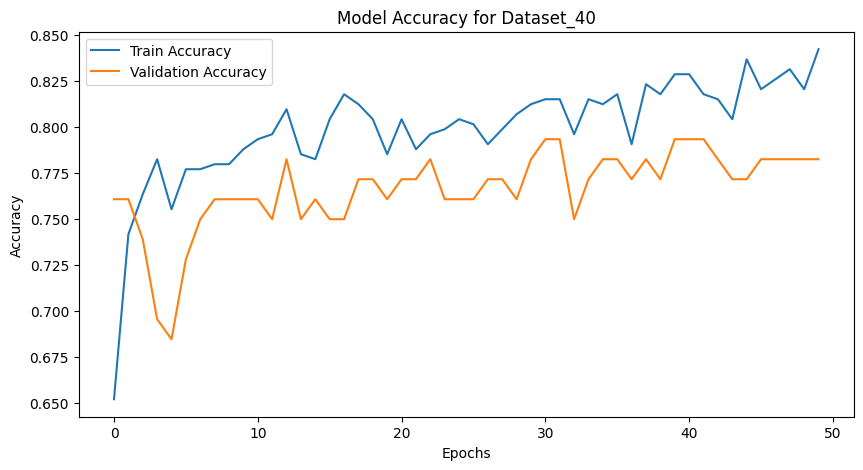

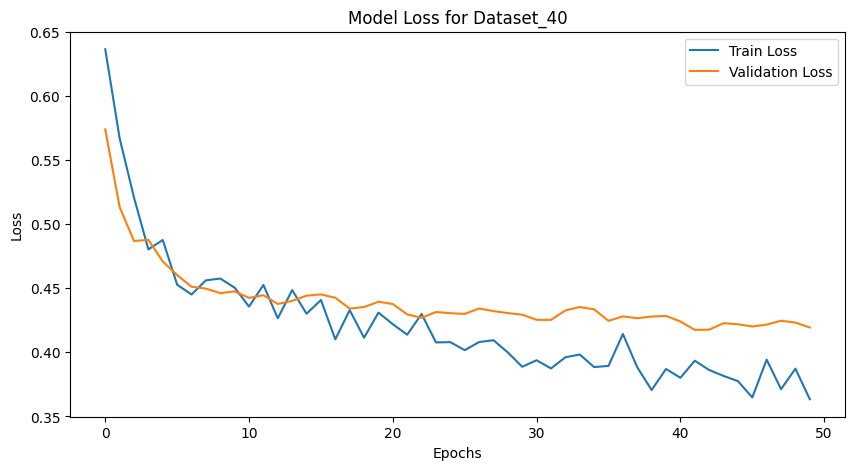

In [6]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Model Accuracy for {dataset}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss for {dataset}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()